In [1]:
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.linalg import solve
from mpl_toolkits import mplot3d
from functools import reduce
from scipy import stats
from sklearn.linear_model import LinearRegression

Definimos las funciones que vamos a necesitar para el programa: el sistema de Lorentz y el método de runge Kutta

In [2]:
def metodo_Rk(f,t0,X0,t_final,h):
    n = round((t_final-t0)/h)
    t=np.linspace(t0,t_final,n+1)
    m = len(X0)
    x = np.zeros((n+1, m), dtype='float64')
    x[0] = X0
    for i in range(n):
        k1 = h * f(x[i])
        k2 = h * f(x[i] + k1/2)
        k3 = h * f(x[i] + k2/2)
        k4 = h * f(x[i] + k3)
        x[i+1] = x[i] + (k1 + 2*k2 + 2*k3 + k4) / float(6)
    return t, x

def sistema_lorentz(x):
    sigma=10
    rho=30
    beta=8/3
    dx_dt=sigma*(x[1]-x[0])
    dy_dt=x[0]*(rho-x[2])-x[1]
    dz_dt=x[0]*x[1]-beta*x[2]
    return np.array([dx_dt,dy_dt,dz_dt])

def comparador_matriz(tol,matriz,parada):
    filas, columnas = matriz.shape
    j=0
    while j<columnas:
        for i in range(filas):
             if abs(matriz[i,j]) >=tol:
                parada[j]=i
                if j==2:
                    return(parada)
                break
        j=j+1
        
def modulo(matriz,t):
    filas=len(t)
    vector=np.zeros(len(t))
    for i in range(filas):
             vector[i]=math.sqrt(matriz[i,0]**2 + matriz[i,1]**2 + matriz[i,2]**2)
    return vector
        

Definimos nuestras condiciones iniciales, tiempos y la pequeñas perturbación que sentirá mi sistemas $\delta=10^{-15}$


In [3]:
X01=np.array([0.,1.,0.])#Condicion inicial.
perturbacion=1e-15
X02=np.array([0.,1+perturbacion,0.])#Condicion inicial con una leve perturbación de 1*10^-15
t0=100
t_final=200
h=0.001

Llamamos a las funciones y las graficamos

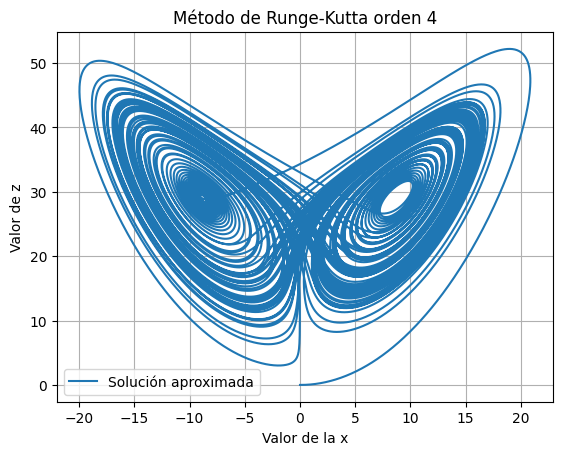

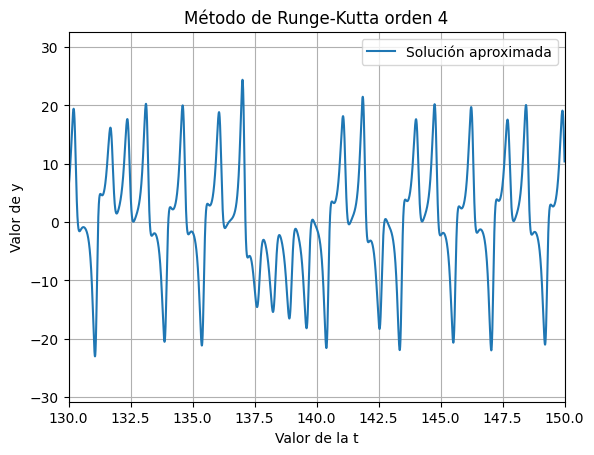

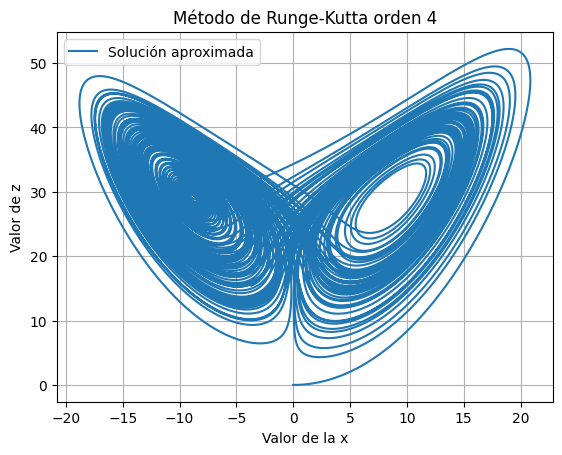

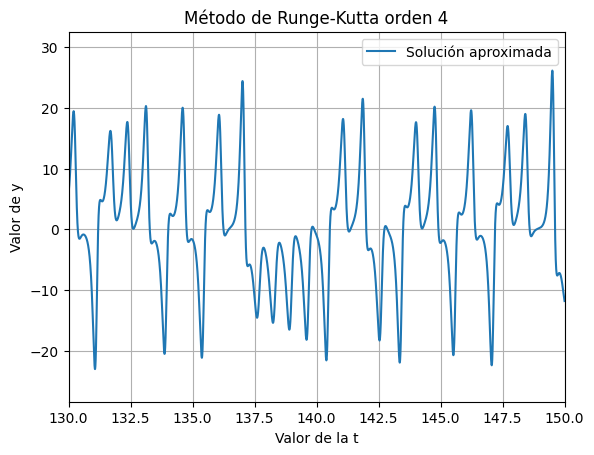

In [4]:
t,x=metodo_Rk(sistema_lorentz,t0,X01,t_final,h)

plt.plot(x[:,0],x[:,2], label='Solución aproximada')

plt.xlabel('Valor de la x')
plt.ylabel('Valor de z')
plt.title('Método de Runge-Kutta orden 4')
plt.legend()
plt.grid(True)
plt.show()
plt.plot(t,x[:,1] , label='Solución aproximada')

plt.xlabel('Valor de la t')
plt.ylabel('Valor de y')
plt.title('Método de Runge-Kutta orden 4')
plt.xlim(130,150)
plt.legend()
plt.grid(True)
plt.show()

t,y=metodo_Rk(sistema_lorentz,t0,X02,t_final,h)

plt.plot(y[:,0],y[:,2], label='Solución aproximada')

plt.xlabel('Valor de la x')
plt.ylabel('Valor de z')
plt.title('Método de Runge-Kutta orden 4')
plt.legend()
plt.grid(True)
plt.show()
plt.plot(t,y[:,1] , label='Solución aproximada')

plt.xlabel('Valor de la t')
plt.ylabel('Valor de y')
plt.title('Método de Runge-Kutta orden 4')
plt.xlim(130,150)
plt.legend()
plt.grid(True)
plt.show()

Restamos las matrices calculadas para crear una nueva matriz. Ciclamos esta matriz para ver en que fila empieza a ser distinta de cero.

In [5]:
z=np.zeros((len(x),len(X01)))
z=(y-x)
tol=1e-4
parada=np.array([0,0,0])
parada=comparador_matriz(tol,z,parada) #No entiendo porque no va.
print(parada)


[36827 36757 36861]


Ploteamos los resultados calculados y comparamos a partir del vector parada.

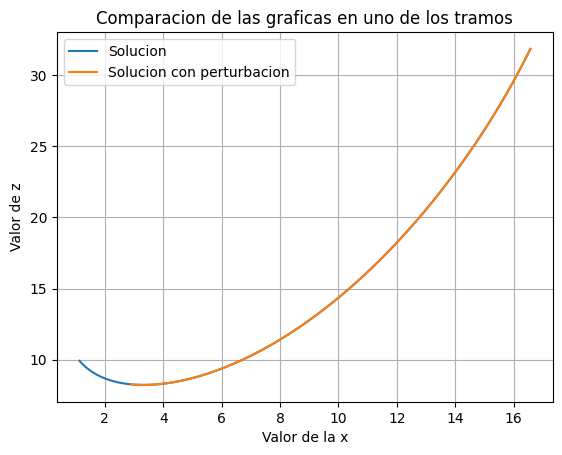

In [6]:
plt.plot(x[parada[0]-100 : parada[0]+200,0],x[parada[0]-100 : parada[0]+200,2], label='Solucion')
plt.plot(y[parada[0] : parada[0]+200,0],y[parada[0] : parada[0]+200,2], label='Solucion con perturbacion')
plt.xlabel('Valor de la x')
plt.ylabel('Valor de z')
plt.title('Comparacion de las graficas en uno de los tramos')
plt.legend()
plt.grid(True)
plt.show()


Hacemos una regresión lineal con la ecuación $\delta(t)$=$\delta _0 *e^{t*\lambda}$.
Para hacerlo cálculo el módulo de cada punto haciendo un nuevo vector que sera $\delta (t)$, hago el logaritmo neperaino para hacer lineal la ecuación y hago una regresión lineal.

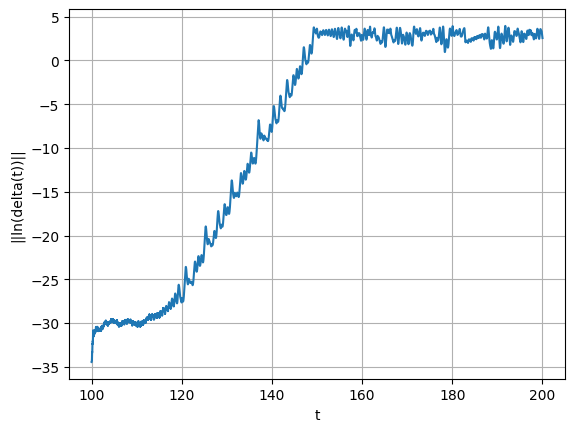

In [7]:

deltaln=np.zeros(len(t))
delta=modulo(z,t)
for i in range(len(t)):
    deltaln[i]=np.log(delta[i])
# y=mx + n m=0.9 y n = 1e-7:.........: y=ln(|delta(t)|) x=t


x=np.linspace(100,200,1000)
plt.plot(t,deltaln)
plt.xlabel('t')
plt.ylabel('||ln(delta(t))||')
plt.grid(True)
plt.show()

Vemos que la pendiente que en la gráfica hay unos puntos que estables los cuales no aportan nada nuevo. Por ello, calcularemos para que t la distancia entre dos puntos de los graficos anteriores se emepeieza a volver estable. La fórmula dada para el tiempo de horizonte depende de $\lambda$, por tanto no podremos utilizarla. (Lo haré a ojo hasta que descubra como hacerlo mejor)

La pendiente es: 0.8890303551951625
La ordenada en el origen es:  -131.76605967658233 que al hacer el logaritmo neperiano sale:  5.9528834586708236e-58
La correlación de la regresión:  0.9910352729949565
2.589996032799775


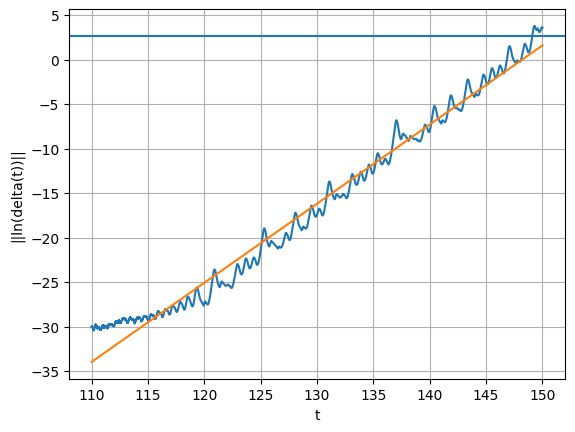

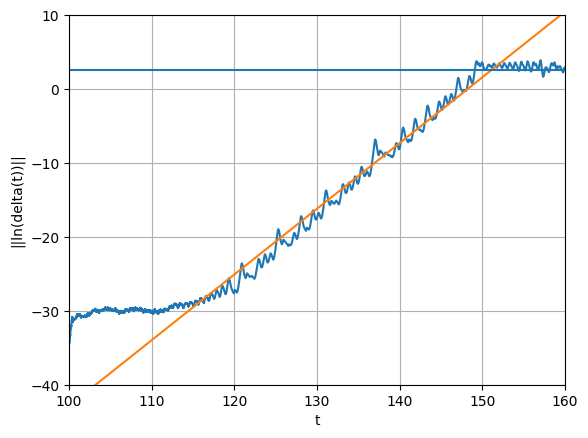

In [8]:
slope1, intercept1, r1, p1, std_err1 = stats.linregress(t[10000 : 50000], deltaln[10000 : 50000])
print('La pendiente es:',slope1)
print('La ordenada en el origen es: ', intercept1, 'que al hacer el logaritmo neperiano sale: ', np.exp(intercept1))
print('La correlación de la regresión: ', r1)
thorizonte=1/slope1*np.log(10**(-14)/perturbacion)
print(thorizonte) 
x=np.linspace(110,150,1000)
plt.plot(t[10000 : 50000], deltaln[10000 : 50000])
plt.plot(x,slope1*x+intercept1)
plt.axhline(thorizonte)
plt.xlabel('t')
plt.ylabel('||ln(delta(t))||')
plt.grid(True)
plt.show()



x=np.linspace(100,200,1000)
plt.plot(t,deltaln)
plt.plot(x,slope1*x+intercept1)
plt.axhline(thorizonte)
plt.xlabel('t')
plt.ylabel('||ln(delta(t))||')
plt.xlim(100,160)
plt.ylim(-40,10)
plt.grid(True)
plt.show()

Calcularemos de otra forma la más precisa la pendiente y además podremos sacar para que iteración es óptimo hacer la iteración. Dado que el vector media está al reves, de mayor a menor, he tenido que buscar el primer mínimo de las ultimas iteraciones, osea, ha tenido que ser el tercer mínimo.

In [25]:
LV=int(len(t)/1000) #Longitud de mi vector de medias
media= np.zeros(LV)
for l in range(LV):
    k=0
    suma=0
    while k<=1000:
        for i in (len(t)-l*1000-1,len(t)-l*1000-1001):
            k=k+1
            suma=suma+deltaln[i]
            if k==1000:
                media[l]=suma/k
#Creamos un algoritmo para ver la iteración máxima antes de la estabilidad
mayor=0 #Para el siguiente algoritmo y ver cual es la diferencia máxima
valoritermax=0 #donde se guarda la iteracion maxima que estamos buscando
for k in range(1,LV-1):
    if (media[k]-abs(media[k+1]))>mayor:
        mayor = media[k]-media[k+1]
        valoritermax=len(t)-k*1000
#Creamos un vector marcadores para que guarde las iteraciones minimas.
iteraciones=np.zeros(LV+1) #iteraciones
marcadores=np.zeros(LV+1) #marcadores de hasta donde van los for

k=0
marcadores[k]=int((-valoritermax+len(t))/1000)
v=False

menor=media[int((len(t)-valoritermax)/1000)+1]- media[int((len(t)-valoritermax)/1000+2)] #Es algo para comprobar una de las medidas

while v != True:

    for i in range(int(marcadores[k]),LV-1):
        if abs(media[i+1]-media[i])<menor:
            menor=abs(media[i+1]-media[i])
            iteraciones[k]=len(t)-(i+1)*1000
    slope1, intercept1, r1, p1, std_err1 = stats.linregress(t[int(iteraciones[k+1]) : valoritermax], deltaln[int(iteraciones[k+1]) : valoritermax])

    if slope1 >=0.9 and slope1<= 0.91:
        v==True
    else:
        k=k+1
        marcadores[k]=int((-marcadores+len(t))/1000+1)
        menor=menor+1  

0.7256843518834611


TypeError: only length-1 arrays can be converted to Python scalars

In [ ]:
LV=int(len(t)/1000) #Longitud de mi vector de medias
media= np.zeros(LV)
for l in range(LV):
    k=0
    suma=0
    while k<=1000:
        for i in (len(t)-l*1000-1,len(t)-l*1000-1001):
            k=k+1
            suma=suma+deltaln[i]
            if k==1000:
                media[l]=suma/k
mayor=0 #Para el siguiente algoritmo y ver cual es la diferencia máxima
valoritermax=0#donde se guarda la iteracion maxima que estamos buscando

for k in range(1,LV-1):
    if (media[k]-abs(media[k+1]))>mayor:
        mayor = media[k]-media[k+1]
        valoritermax=len(t)-k*1000
print(valoritermax)
#Valor máximo de las iteraciones

menor=media[int((len(t)-valoritermax)/1000)+1]- media[int((len(t)-valoritermax)/1000+2)]

#Primer mínimo.
for k in range(int((-valoritermax+len(t))/1000),LV-1):
    if abs(media[k+1]-media[k])<menor:
        menor=abs(media[k+1]-media[k])
        primer=len(t)-(k+1)*1000 
print(primer)
menor=menor+1

#Segundo mínimo
for k in range(int((-primer+len(t))/1000+1),LV-1):
     if abs(media[k+1]-media[k])<menor:
        menor=abs(media[k+1]-media[k])
        segundo=len(t)-(k+1)*1000 
print(segundo)
menor=menor+1

#Tercer mínimo.
for k in range(int((-segundo+len(t))/1000+1),LV-1):
     if abs(media[k+1]-media[k])<menor:
        menor=abs(media[k+1]-media[k])
        tercero=len(t)-(k+1)*1000 
print(tercero)

50001
19001
14001
11001


Vamos a probar nuestro algoritmo

La pendiente es: 0.9028312285161502
La ordenada en el origen es:  -133.65434011647213 que al hacer el logaritmo neperiano sale:  9.008606247802975e-59
La correlación de la regresión:  0.9921888817149013
2.5504047935719543


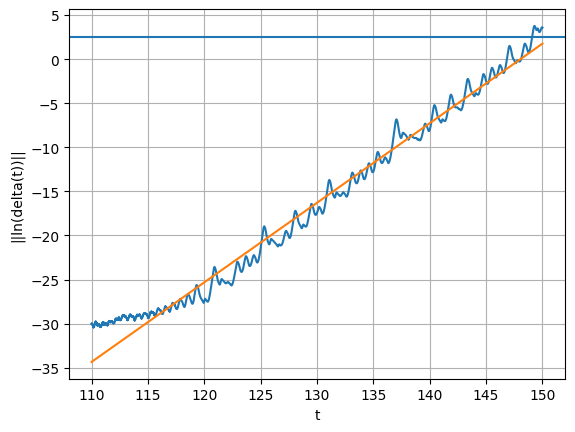

In [ ]:
slope1, intercept1, r1, p1, std_err1 = stats.linregress(t[tercero : valoritermax], deltaln[tercero : valoritermax])
print('La pendiente es:',slope1)
print('La ordenada en el origen es: ', intercept1, 'que al hacer el logaritmo neperiano sale: ', np.exp(intercept1))
print('La correlación de la regresión: ', r1)
thorizonte=1/slope1*np.log(10**(-14)/perturbacion)
print(thorizonte)
x=np.linspace(110,150,1000)
plt.plot(t[10000 : 50000], deltaln[10000 : 50000])
plt.plot(x,slope1*x+intercept1)
plt.axhline(thorizonte)
plt.xlabel('t')
plt.ylabel('||ln(delta(t))||')
plt.grid(True)
plt.show()


Como comprabamos el resultado se aleja de 0.9 no por mucho 0.02. Esto es debido a que no hemos tomado en consideración que las primeras iteraciones no aportan nada ya que son los puntos donde ambos recorridos son similares.

La pendiente es: 0.9669555310314683
La ordenada en el origen es:  -142.39090376321238 que al hacer el logaritmo neperiano sale:  1.44682572624633e-62
La correlación de la regresión:  0.969599989203023
2.3812729945686733


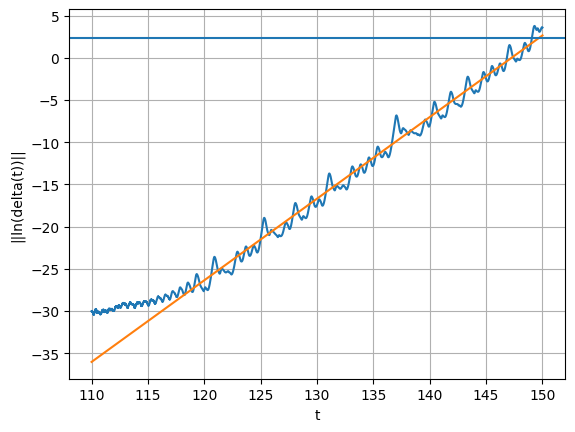

In [ ]:
slope1, intercept1, r1, p1, std_err1 = stats.linregress(t[parada[1] : valoritermax], deltaln[parada[1] : valoritermax])
print('La pendiente es:',slope1)
print('La ordenada en el origen es: ', intercept1, 'que al hacer el logaritmo neperiano sale: ', np.exp(intercept1))
print('La correlación de la regresión: ', r1)
thorizonte=1/slope1*np.log(10**(-14)/perturbacion)
print(thorizonte)
x=np.linspace(110,150,1000)
plt.plot(t[10000 : 50000], deltaln[10000 : 50000])
plt.plot(x,slope1*x+intercept1)
plt.axhline(thorizonte)
plt.xlabel('t')
plt.ylabel('||ln(delta(t))||')
plt.grid(True)
plt.show()

Vemos que la pendiente sale mas cercano al valor esperado, sin embargo la correlación entre ambas variables a disminuido considerablemente. El error del 0.04 que dista del valor esperado, seguramente, sea del valor de la tolerancia a la hora de calcular la parada. Necesitaría calcular el valor óptimo para el cual el error cometido se mínimo. 